# Logistic Regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Load Data

In [3]:
data_clean = "../data/clean/data_clean.csv"
train_subsam = "../data/clean/train_subsam.csv"
train_smote = "../data/clean/train_smote.csv"
clean_train = "../data/clean/clean_train.csv"
clean_val = "../data/clean/clean_val.csv"
clean_test = "../data/clean/clean_test.csv"

rnd_split = 44
rnd_logreg = 44
rnd_shap = 44

num_cols = ["Term","NoEmp","SecuredSBA","GrDisburs","GrApprov","ApprovSBA"]
target = ["Default"]

In [4]:
df = pd.read_csv(data_clean, low_memory=False)
df

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default
0,15,38,1,16,30,2,84,4,0,1,0,0,0,1,60000,60000,48000,80,0
1,15,18,0,0,30,2,60,2,0,1,0,0,0,1,40000,40000,32000,80,0
2,15,18,0,7,30,2,180,7,0,0,0,0,0,0,287000,287000,215250,75,0
3,36,39,0,20,30,2,60,2,0,0,0,0,0,1,35000,35000,28000,80,0
4,9,11,0,20,30,2,240,14,1,0,0,0,0,0,229000,229000,229000,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894605,35,17,1,16,30,2,60,6,0,0,0,0,0,0,70000,70000,56000,80,0
894606,35,17,1,16,30,2,60,6,0,0,0,0,1,0,85000,85000,42500,50,0
894607,4,5,0,10,30,2,108,26,0,0,0,0,0,0,300000,300000,225000,75,0
894608,11,14,0,20,30,2,60,6,0,0,0,0,0,1,75000,75000,60000,80,1


## Feature Scaling

### Min-Max Scaling

Algoritmos sensibles a la escala, como k-Nearest Neighbors (k-NN) y redes neuronales con funciones de activación basadas en distancias (como la función sigmoide), pueden beneficiarse de la normalización.

In [ ]:
# scaler = MinMaxScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

# df.sample(3)

### Z-Score Scaling

Algunos algoritmos, como la Regresión Logística y el Support Vector Machine (SVM), funcionan mejor con datos estandarizados, ya que asumen una distribución normal.

In [5]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.sample(3)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default
19045,43,47,0,7,30,4,2.394339,0.007693,1,0,0,0,0,1,-0.528141,-0.506090,-0.481656,0.519006,0
500273,28,31,0,4,25,6,-0.340847,0.318954,0,0,0,0,0,0,1.902829,1.962350,1.967252,0.519006,0
291114,10,5,1,5,41,4,-0.340847,-0.114104,0,1,1,0,0,0,-0.666687,-0.646771,-0.619038,0.806884,0


## Split Data

In [6]:
X = df.drop(columns=target)
y = df[target[0]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    random_state=rnd_split)

In [8]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test:  {X_test.shape}, {y_test.shape}")

Train: (626227, 18), (626227,)
Test:  (268383, 18), (268383,)


## Model Training

### Model Tuning

In [9]:
param_grid = {"C": [0.01, 0.1, 1, 10, 100],
              "penalty": ["l1", "l2"],
              "random_state": [rnd_logreg]}

In [ ]:
grid_lr = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_lr.fit(X_train, y_train)

In [12]:
params = grid_lr.best_params_

print("Better Parameters:", params)

Better Parameters: {'C': 0.01, 'penalty': 'l2', 'random_state': 44}


In [13]:
lr_model = LogisticRegression(C=params["C"], penalty=params["penalty"],
                              random_state=params["random_state"], max_iter=1000)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, random_state=44)

In [14]:
acc_lr = lr_model.score(X_test, y_test)

print("Accuracy:", round(acc_lr, 4))

Accuracy: 0.8535


### Feature Importance

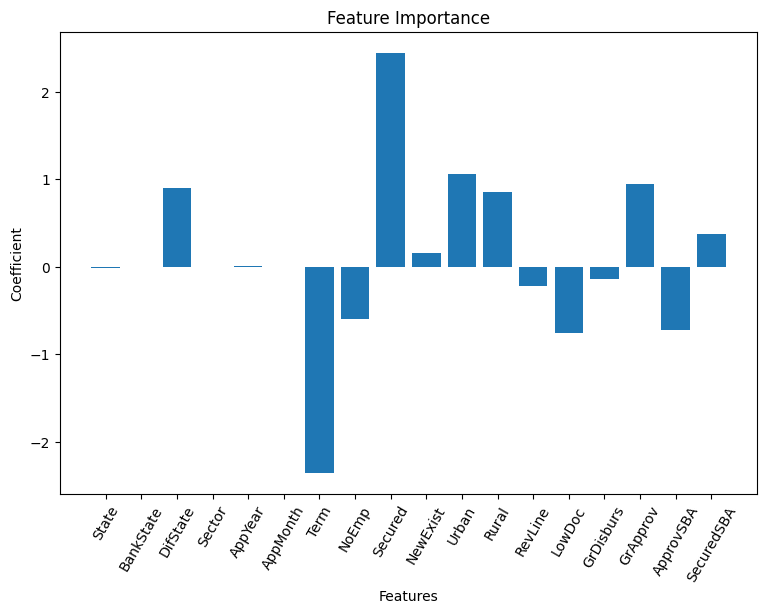

In [15]:
coef_lr = lr_model.coef_[0]
X_cols = X_train.columns

plt.figure(figsize=(9, 6))
plt.bar(X_cols, coef_lr)

plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.xticks(rotation=60)
plt.show()

### Recursive Feature Elimination

In [16]:
lr_ref = LogisticRegression(C=params["C"], penalty=params["penalty"],
                            random_state=params["random_state"], max_iter=1000)

In [17]:
rfe_lr = RFE(lr_ref)
rfe_lr.fit(X_train, y_train)

RFE(estimator=LogisticRegression(C=0.01, max_iter=1000, random_state=44))

In [18]:
rfe_mat = list(zip(X_train.columns.values.tolist(), rfe_lr.support_, rfe_lr.ranking_))
rfe_mat

[('State', False, 6),
 ('BankState', False, 8),
 ('DifState', True, 1),
 ('Sector', False, 9),
 ('AppYear', False, 7),
 ('AppMonth', False, 10),
 ('Term', True, 1),
 ('NoEmp', True, 1),
 ('Secured', True, 1),
 ('NewExist', False, 4),
 ('Urban', True, 1),
 ('Rural', True, 1),
 ('RevLine', False, 3),
 ('LowDoc', True, 1),
 ('GrDisburs', False, 5),
 ('GrApprov', True, 1),
 ('ApprovSBA', True, 1),
 ('SecuredSBA', False, 2)]

In [19]:
sel_cols = [tupla[1] for tupla in rfe_mat]
X_train.loc[:, sel_cols].columns

Index(['DifState', 'Term', 'NoEmp', 'Secured', 'Urban', 'Rural', 'LowDoc',
       'GrApprov', 'ApprovSBA'],
      dtype='object')

In [20]:
lr_ref.fit(X_train.loc[:, sel_cols], y_train)

LogisticRegression(C=0.01, max_iter=1000, random_state=44)

In [21]:
y_ref = lr_ref.predict(X_test.loc[:,sel_cols])
acc_ref = accuracy_score(y_test, y_ref)

print("Accuracy:", round(acc_ref, 4))

Accuracy: 0.8469


### Custom Threshold

In [22]:
y_prob = lr_model.predict_proba(X_train)[:, 1]
threshold = 0.4 # p <= 0.4 => 0, p > 0.4 => 1

y_prob = (y_prob >= threshold).astype(int)

In [23]:
acc_ct = accuracy_score(y_train, y_prob)

print("Accuracy:", round(acc_ct, 4))

Accuracy: 0.8613


### Balanced Datasets

**Subsample Dataset**

In [24]:
df_under = pd.read_csv(train_subsam, low_memory=False)
df_under["Default"].value_counts()

Default
0    109827
1    109827
Name: count, dtype: int64

In [25]:
scaler = StandardScaler()
df_under[num_cols] = scaler.fit_transform(df_under[num_cols])

In [26]:
X_under = df_under.drop(columns=target)
y_under = df_under[target[0]]

In [27]:
lr_under = LogisticRegression(C=params["C"], penalty=params["penalty"],
                              random_state=params["random_state"], max_iter=1000)
lr_under.fit(X_under, y_under)

LogisticRegression(C=0.01, max_iter=1000, random_state=44)

In [28]:
acc_und = lr_under.score(X_test, y_test)

print("Accuracy:", round(acc_und, 4))

Accuracy: 0.612


**SMOTE Dataset**

In [29]:
df_smote = pd.read_csv(train_smote, low_memory=False)
df_smote["Default"].value_counts()

Default
0    516843
1    516843
Name: count, dtype: int64

In [30]:
scaler = StandardScaler()
df_smote[num_cols] = scaler.fit_transform(df_smote[num_cols])

In [31]:
X_smote = df_smote.drop(columns=target)
y_smote = df_smote[target[0]]

In [32]:
lr_smote = LogisticRegression(C=params["C"], penalty=params["penalty"],
                              random_state=params["random_state"], max_iter=1000)
lr_smote.fit(X_smote, y_smote)

LogisticRegression(C=0.01, max_iter=1000, random_state=44)

In [33]:
acc_sm = lr_smote.score(X_test, y_test)

print("Accuracy:", round(acc_sm, 4))

Accuracy: 0.6258


## Model Evaluation

### Cross-Validation

**Trained Model**

In [34]:
results = cross_val_score(lr_model, X_train, y_train, cv=10)

print("Results:", results)
print("Accuracy (mean +/- desv): %0.4f +/- %0.4f" % (results.mean(), results.std()))

Results: [0.85391949 0.8543187  0.85495744 0.85447839 0.85417498 0.85352027
 0.85585168 0.85217655 0.8554821  0.85423653]
Accuracy (mean +/- desv): 0.8543 +/- 0.0010


In [35]:
y_cv_tr = cross_val_predict(lr_model, X_train, y_train, cv=10)
acc_cv_tr = accuracy_score(y_train, y_cv_tr)

print("Accuracy Train:", round(acc_cv_tr, 4))

Accuracy Train: 0.8543


In [36]:
y_cv_ts = cross_val_predict(lr_model, X_test, y_test, cv=10)
acc_cv_ts = accuracy_score(y_test, y_cv_ts)

print("Accuracy Test:", round(acc_cv_ts, 4))

Accuracy Test: 0.8531


**Custom Threshold**

In [37]:
y_prob_cv = cross_val_predict(lr_model, X_test, y_test, cv=10, method="predict_proba")

threshold = 0.4
y_prob_cv = (y_prob_cv[:, 1] >= threshold).astype(int)

In [38]:
acc_cv_ct = accuracy_score(y_test, y_prob_cv)

print("Accuracy:", round(acc_cv_ct, 4))

Accuracy: 0.8611


**Model Scores**

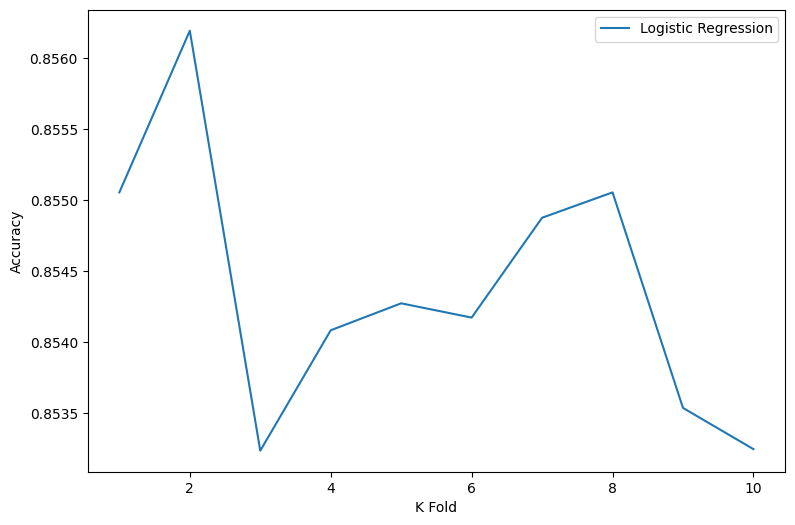

In [39]:
kf = KFold(n_splits=10, shuffle=True)
scores = cross_val_score(lr_model, X, y, cv=kf, scoring="accuracy")

plt.figure(figsize=(9, 6))
plt.plot(range(1, 11), scores, label="Logistic Regression")

plt.xlabel("K Fold")
plt.ylabel("Accuracy")
# plt.xlim([1, 10])
# plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

### Classification Metrics

**Classification Report**

In [40]:
y_pred = lr_model.predict(X_test)

In [41]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8535
Precisión:    0.7861
Sensibilidad: 0.6343
F1-score:     0.6662


In [42]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8651    0.9737    0.9162    220842
           1     0.7070    0.2950    0.4163     47541

    accuracy                         0.8535    268383
   macro avg     0.7861    0.6343    0.6662    268383
weighted avg     0.8371    0.8535    0.8277    268383



**Confusion Matrix**

In [43]:
cm_lr = confusion_matrix(y_test, y_pred, normalize="all")
print(cm_lr)

[[0.80120947 0.02165189]
 [0.12488869 0.05224996]]


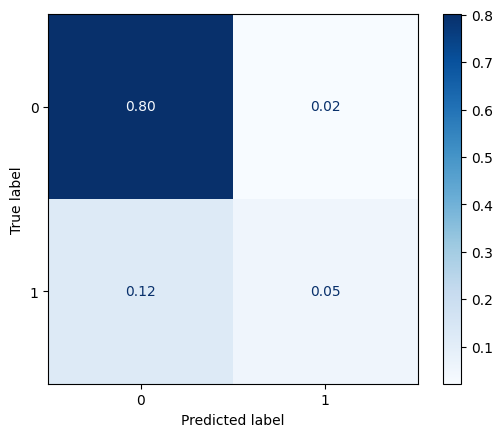

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                              display_labels=lr_model.classes_)
disp.plot(cmap="Blues", values_format=".2f")

**ROC (Receiver Operating Characteristic) Curve**

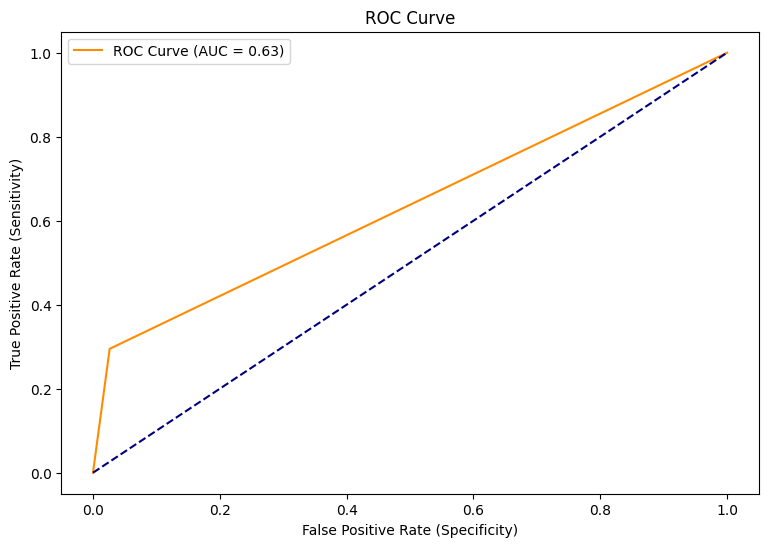

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, color="darkorange", label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.legend()
plt.show()

### Interpretability

In [46]:
X_train_sample = X_train.sample(frac=0.0001, random_state=rnd_shap)
X_test_sample = X_test.sample(frac=0.0001, random_state=rnd_shap)

In [47]:
explainer = shap.KernelExplainer(lr_model.predict_proba, X_train_sample)
shap_values = explainer.shap_values(X_test_sample)

100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


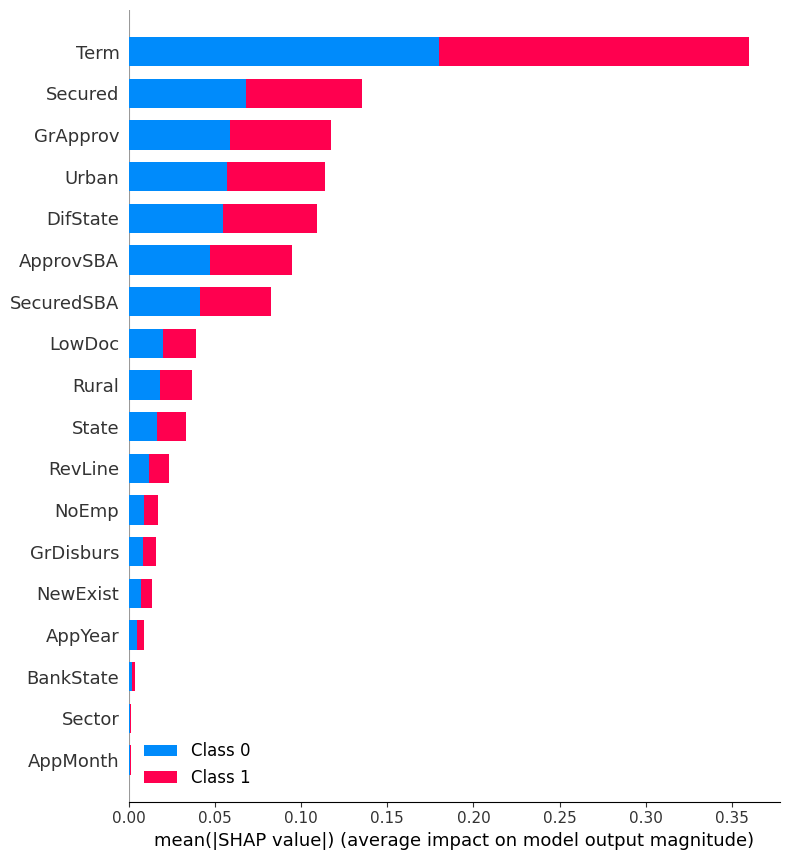

In [48]:
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns)

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_sample)

In [50]:
row_show = 10
data_pred = X_test_sample.iloc[row_show]
data_pred_array = data_pred.values.reshape(1, -1)

lr_model.predict_proba(data_pred_array)

X does not have valid feature names, but LogisticRegression was fitted with feature names


array([[0.85278342, 0.14721658]])

In [51]:
shap_values = explainer.shap_values(data_pred_array)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_pred_array, feature_names=X_test_sample.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


## Model Pipeline

In [52]:
df_train = pd.read_csv(clean_train)
df_val = pd.read_csv(clean_val)
df_test = pd.read_csv(clean_test)

X_train = df_train.drop(columns=target)
y_train = df_train[target[0]]

X_val = df_val.drop(columns=target)
y_val = df_val[target[0]]

X_test = df_test.drop(columns=target)
y_test = df_test[target[0]]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(626670, 19)
(134552, 19)
(134498, 19)


### Create the Pipeline

In [53]:
class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        self.encoders = {}

    def fit(self, X, y=None):
        for var in self.variables:
            encoder = StandardScaler()
            encoder.fit(X[var].values.reshape(-1, 1))
            self.encoders[var] = encoder
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for var, encoder in self.encoders.items():
            X[var] = encoder.transform(X[var].values.reshape(-1, 1))
        return X

In [54]:
class LogisticRegressionModel(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.log_reg = LogisticRegression(C=0.1, penalty="l2",
                                          random_state=rnd_logreg, max_iter=1000)
        self.threshold = 0.4

    def fit(self, X, y):
        self.log_reg.fit(X, y)
        return self

    def transform(self, X):
        return X

    def predict(self, X, y=None):
        y_prob = self.log_reg.predict_proba(X)[:, 1]
        y_pred = (y_prob >= self.threshold).astype(int)
        return y_pred

In [55]:
logreg_pipeline = Pipeline([
    ("scaler", ZScoreTransformer(num_cols)),
    ("custom_model", LogisticRegressionModel())
    ])

### Test the Pipeline

**Internal Partition**

In [56]:
logreg_pipeline.fit_transform(X_train, y_train)

y_pred = logreg_pipeline.predict(X_val)

In [57]:
print("Exactitud:    %.4f" % (accuracy_score(y_val, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_val, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_val, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_val, y_pred, average="macro")))

Exactitud:    0.8612
Precisión:    0.7703
Sensibilidad: 0.7097
F1-score:     0.7330


**External Partition**

In [58]:
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

print(f"Train: {X_train.shape} {y_train.shape}")

Train: (761222, 18) (761222,)


In [59]:
logreg_pipeline.fit_transform(X_train, y_train)

y_pred = logreg_pipeline.predict(X_test)

In [60]:
print("Exactitud:    %.4f" % (accuracy_score(y_test, y_pred)))
print("Precisión:    %.4f" % (precision_score(y_test, y_pred, average="macro")))
print("Sensibilidad: %.4f" % (recall_score(y_test, y_pred, average="macro")))
print("F1-score:     %.4f" % (f1_score(y_test, y_pred, average="macro")))

Exactitud:    0.8612
Precisión:    0.7713
Sensibilidad: 0.7085
F1-score:     0.7324


### Save the Pipeline

In [66]:
joblib.dump(logreg_pipeline, "../models/logreg_model.joblib")

logreg_model = joblib.load("../models/logreg_model.joblib")

try:
    logreg_model
    print(f"Logistic Regression is loaded...")

except Exception as err:
    print("Error:", str(err))

Logistic Regression is loaded...


In [67]:
y_pred = logreg_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [68]:
df_ = pd.concat([X_test, y_test, pd.DataFrame({"Pred": y_pred})], axis=1)
df_.sample(10)

,State,BankState,DifState,Sector,AppYear,AppMonth,Term,NoEmp,Secured,NewExist,Urban,Rural,RevLine,LowDoc,GrDisburs,GrApprov,ApprovSBA,SecuredSBA,Default,Pred
115713,39,43,0,19,36,1,62,3,0,0,1,0,1,0,50000,50000,25000,50,0,0
91898,4,37,1,16,40,8,10,2,0,0,1,0,1,0,50000,50000,25000,50,1,1
122511,22,17,1,7,35,9,123,8,0,1,0,0,0,0,215800,215800,161850,75,0,0
68360,43,1,1,1,42,8,84,3,0,0,1,0,1,0,20000,20000,10000,50,0,0
83809,44,48,0,10,39,3,178,2,0,1,0,1,1,0,62804,25000,12500,50,0,0
98961,18,47,1,20,29,7,87,20,0,0,0,0,0,0,227500,227500,170625,75,0,0
36521,39,9,1,13,37,2,119,3,0,0,1,0,1,0,136000,100000,50000,50,0,0
114377,34,5,1,0,33,11,120,6,0,0,1,0,0,0,95000,95000,76000,80,0,0
51770,48,53,0,3,42,8,60,3,0,1,1,0,0,0,75600,75600,37800,50,0,0
38323,4,5,0,16,36,12,84,1,0,0,1,0,0,0,5000,5000,4250,85,0,0
